# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [7]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [8]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.349380847965382 -2.602122511534467
actions: 1 0
rewards: 1.0 1.0


In [9]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [10]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [12]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [13]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [120]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [121]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [122]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [123]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [124]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [126]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    #g_loss = -tf.reduce_mean(Qs)
    
    # D
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs)
    return actions_logits, Qs, g_loss, d_loss

In [127]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [128]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [129]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [130]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1000, 4) actions:(1000,)
action size:2


In [131]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
# state_size = 37
# state_size_ = (84, 84, 3)
state_size = 4
action_size = 2
hidden_size = 64             # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
gamma = 0.99                   # future reward discount
memory_size = 1000            # memory capacity
batch_size = 1000             # experience mini-batch size

In [132]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [133]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            #batch = memory.sample(batch_size)
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0 gloss:-0.0007 dloss:1.0030 exploreP:0.9977
Episode:1 meanR:17.0000 R:11.0 gloss:0.0363 dloss:1.0008 exploreP:0.9966
Episode:2 meanR:18.6667 R:22.0 gloss:0.0768 dloss:1.0006 exploreP:0.9945
Episode:3 meanR:18.0000 R:16.0 gloss:0.1302 dloss:1.0024 exploreP:0.9929
Episode:4 meanR:25.0000 R:53.0 gloss:0.2474 dloss:1.0169 exploreP:0.9877
Episode:5 meanR:26.3333 R:33.0 gloss:0.4136 dloss:1.0568 exploreP:0.9845
Episode:6 meanR:24.5714 R:14.0 gloss:0.5086 dloss:1.0915 exploreP:0.9831
Episode:7 meanR:23.2500 R:14.0 gloss:0.5681 dloss:1.1156 exploreP:0.9818
Episode:8 meanR:22.6667 R:18.0 gloss:0.6377 dloss:1.1432 exploreP:0.9800
Episode:9 meanR:22.6000 R:22.0 gloss:0.7414 dloss:1.1884 exploreP:0.9779
Episode:10 meanR:21.8182 R:14.0 gloss:0.8487 dloss:1.2355 exploreP:0.9765
Episode:11 meanR:21.9167 R:23.0 gloss:0.9704 dloss:1.2932 exploreP:0.9743
Episode:12 meanR:22.7692 R:33.0 gloss:1.1725 dloss:1.3939 exploreP:0.9711
Episode:13 meanR:22.9286 R:25.0 gloss:1.4139 dl

Episode:109 meanR:24.1100 R:12.0 gloss:11.4179 dloss:13.7543 exploreP:0.7705
Episode:110 meanR:24.2100 R:24.0 gloss:11.2950 dloss:13.3022 exploreP:0.7687
Episode:111 meanR:24.1400 R:16.0 gloss:11.3596 dloss:13.5755 exploreP:0.7675
Episode:112 meanR:23.9600 R:15.0 gloss:11.3259 dloss:13.5977 exploreP:0.7664
Episode:113 meanR:23.9100 R:20.0 gloss:11.1753 dloss:13.4543 exploreP:0.7648
Episode:114 meanR:24.1600 R:58.0 gloss:11.1796 dloss:13.2092 exploreP:0.7605
Episode:115 meanR:24.0800 R:19.0 gloss:11.5199 dloss:13.6644 exploreP:0.7590
Episode:116 meanR:23.9100 R:19.0 gloss:11.5084 dloss:13.6340 exploreP:0.7576
Episode:117 meanR:23.6600 R:15.0 gloss:11.5398 dloss:13.9141 exploreP:0.7565
Episode:118 meanR:23.6600 R:13.0 gloss:11.4187 dloss:13.7802 exploreP:0.7555
Episode:119 meanR:22.9600 R:16.0 gloss:11.2712 dloss:13.5774 exploreP:0.7543
Episode:120 meanR:22.8300 R:19.0 gloss:11.1522 dloss:13.3770 exploreP:0.7529
Episode:121 meanR:22.6800 R:18.0 gloss:11.1184 dloss:13.3168 exploreP:0.7516

Episode:216 meanR:21.2600 R:44.0 gloss:10.6012 dloss:13.8935 exploreP:0.6144
Episode:217 meanR:21.2400 R:13.0 gloss:10.7112 dloss:14.1547 exploreP:0.6137
Episode:218 meanR:21.2000 R:9.0 gloss:10.7099 dloss:14.2473 exploreP:0.6131
Episode:219 meanR:21.3100 R:27.0 gloss:10.5986 dloss:14.1003 exploreP:0.6115
Episode:220 meanR:21.2500 R:13.0 gloss:10.4463 dloss:14.0754 exploreP:0.6107
Episode:221 meanR:21.2500 R:18.0 gloss:10.2974 dloss:13.7140 exploreP:0.6096
Episode:222 meanR:21.2100 R:13.0 gloss:10.2407 dloss:13.6147 exploreP:0.6088
Episode:223 meanR:21.0600 R:11.0 gloss:10.2193 dloss:13.8577 exploreP:0.6082
Episode:224 meanR:21.0500 R:13.0 gloss:10.1104 dloss:13.6401 exploreP:0.6074
Episode:225 meanR:20.9200 R:19.0 gloss:10.0594 dloss:13.4247 exploreP:0.6063
Episode:226 meanR:21.0000 R:18.0 gloss:10.0431 dloss:13.4911 exploreP:0.6052
Episode:227 meanR:21.0400 R:20.0 gloss:10.1277 dloss:13.4572 exploreP:0.6040
Episode:228 meanR:21.0100 R:18.0 gloss:10.1188 dloss:13.5535 exploreP:0.6029


Episode:324 meanR:19.0000 R:18.0 gloss:8.5882 dloss:12.4234 exploreP:0.5040
Episode:325 meanR:18.9400 R:13.0 gloss:8.6113 dloss:12.5891 exploreP:0.5034
Episode:326 meanR:18.9300 R:17.0 gloss:8.5228 dloss:12.3996 exploreP:0.5026
Episode:327 meanR:18.9000 R:17.0 gloss:8.4864 dloss:12.3412 exploreP:0.5017
Episode:328 meanR:18.9000 R:18.0 gloss:8.5536 dloss:12.4110 exploreP:0.5008
Episode:329 meanR:19.0000 R:22.0 gloss:8.5479 dloss:12.3668 exploreP:0.4998
Episode:330 meanR:19.0800 R:23.0 gloss:8.6460 dloss:12.5370 exploreP:0.4986
Episode:331 meanR:19.1800 R:29.0 gloss:8.6928 dloss:12.6438 exploreP:0.4972
Episode:332 meanR:19.1700 R:16.0 gloss:8.8287 dloss:12.8509 exploreP:0.4964
Episode:333 meanR:19.3100 R:33.0 gloss:8.6522 dloss:12.6131 exploreP:0.4948
Episode:334 meanR:19.3400 R:25.0 gloss:8.6446 dloss:12.7246 exploreP:0.4936
Episode:335 meanR:19.6400 R:45.0 gloss:8.7551 dloss:12.7011 exploreP:0.4915
Episode:336 meanR:19.6200 R:12.0 gloss:8.9186 dloss:13.1051 exploreP:0.4909
Episode:337 

Episode:432 meanR:19.7900 R:12.0 gloss:7.8947 dloss:12.6389 exploreP:0.4091
Episode:433 meanR:19.7900 R:33.0 gloss:7.7488 dloss:12.3727 exploreP:0.4078
Episode:434 meanR:19.6400 R:10.0 gloss:7.8297 dloss:12.6979 exploreP:0.4074
Episode:435 meanR:19.3100 R:12.0 gloss:7.7504 dloss:12.6295 exploreP:0.4069
Episode:436 meanR:19.2900 R:10.0 gloss:7.6111 dloss:12.4111 exploreP:0.4065
Episode:437 meanR:19.3000 R:14.0 gloss:7.4766 dloss:12.1018 exploreP:0.4060
Episode:438 meanR:19.2200 R:13.0 gloss:7.5436 dloss:12.1304 exploreP:0.4054
Episode:439 meanR:19.2000 R:13.0 gloss:7.6032 dloss:12.2553 exploreP:0.4049
Episode:440 meanR:19.1700 R:23.0 gloss:7.5319 dloss:12.1198 exploreP:0.4040
Episode:441 meanR:19.1900 R:17.0 gloss:7.4189 dloss:12.0107 exploreP:0.4034
Episode:442 meanR:19.2500 R:15.0 gloss:7.4658 dloss:12.0125 exploreP:0.4028
Episode:443 meanR:19.1500 R:12.0 gloss:7.5394 dloss:12.1398 exploreP:0.4023
Episode:444 meanR:19.0400 R:9.0 gloss:7.4756 dloss:12.3139 exploreP:0.4019
Episode:445 m

Episode:540 meanR:19.1400 R:12.0 gloss:6.5714 dloss:12.2111 exploreP:0.3354
Episode:541 meanR:19.2300 R:26.0 gloss:6.4754 dloss:12.1993 exploreP:0.3345
Episode:542 meanR:19.2500 R:17.0 gloss:6.4172 dloss:12.2232 exploreP:0.3340
Episode:543 meanR:19.3300 R:20.0 gloss:6.4596 dloss:12.2280 exploreP:0.3333
Episode:544 meanR:19.4000 R:16.0 gloss:6.5191 dloss:12.3056 exploreP:0.3328
Episode:545 meanR:19.3600 R:14.0 gloss:6.5684 dloss:12.3181 exploreP:0.3324
Episode:546 meanR:19.5100 R:31.0 gloss:6.6065 dloss:12.1423 exploreP:0.3314
Episode:547 meanR:19.2600 R:10.0 gloss:6.5943 dloss:12.4508 exploreP:0.3311
Episode:548 meanR:19.2400 R:12.0 gloss:6.4533 dloss:12.0015 exploreP:0.3307
Episode:549 meanR:19.2200 R:18.0 gloss:6.4450 dloss:11.9424 exploreP:0.3301
Episode:550 meanR:19.1200 R:17.0 gloss:6.5615 dloss:12.0354 exploreP:0.3295
Episode:551 meanR:19.3700 R:33.0 gloss:6.4961 dloss:12.0240 exploreP:0.3285
Episode:552 meanR:19.3200 R:15.0 gloss:6.5615 dloss:12.3579 exploreP:0.3280
Episode:553 

Episode:648 meanR:20.0800 R:15.0 gloss:6.8681 dloss:13.8148 exploreP:0.2723
Episode:649 meanR:20.0800 R:18.0 gloss:6.7177 dloss:13.4930 exploreP:0.2719
Episode:650 meanR:20.0000 R:9.0 gloss:6.6588 dloss:13.6607 exploreP:0.2716
Episode:651 meanR:19.8800 R:21.0 gloss:6.5765 dloss:13.2598 exploreP:0.2711
Episode:652 meanR:19.9100 R:18.0 gloss:6.6052 dloss:13.3429 exploreP:0.2706
Episode:653 meanR:19.7900 R:11.0 gloss:6.6001 dloss:13.4133 exploreP:0.2703
Episode:654 meanR:19.8800 R:20.0 gloss:6.4238 dloss:12.9927 exploreP:0.2698
Episode:655 meanR:20.0000 R:23.0 gloss:6.4139 dloss:13.0466 exploreP:0.2692
Episode:656 meanR:19.9800 R:13.0 gloss:6.4376 dloss:13.1192 exploreP:0.2689
Episode:657 meanR:19.9800 R:16.0 gloss:6.3730 dloss:13.0055 exploreP:0.2685
Episode:658 meanR:20.1300 R:28.0 gloss:6.2791 dloss:12.9066 exploreP:0.2677
Episode:659 meanR:20.0500 R:12.0 gloss:6.3856 dloss:13.2528 exploreP:0.2674
Episode:660 meanR:20.0200 R:9.0 gloss:6.2632 dloss:13.0557 exploreP:0.2672
Episode:661 me

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

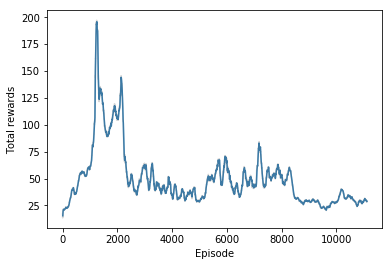

In [106]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

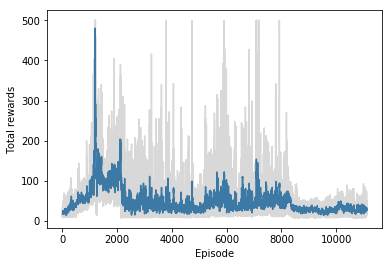

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

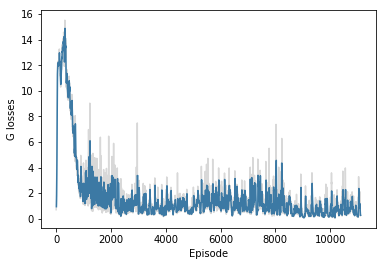

In [103]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

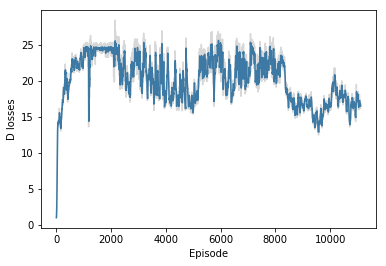

In [104]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.